In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.special
from scipy.stats import multivariate_normal as mvn
%matplotlib inline

In [2]:
from abc import ABC, abstractmethod 
class MixtureModel(ABC):
    def __init__(self, Number_Of_Iterations, Number_Of_Components):
        self.iterations = Number_Of_Iterations
        self.sources = Number_Of_Components
        self.pi_ = None
        self.likelihood = None
        self.previous_likelihood = None
        
     
    @abstractmethod
    def _e_step(self):
        pass
    
    @abstractmethod
    def _m_step(self):
        pass
    
    @abstractmethod
    def predict_proba(self):
        pass
    
    @abstractmethod
    def _sample_component(self):
        pass
    
    def fit(self, X):
        likelihoods = []
        for i in range(0, self.iterations):     
            self.gamma = self._e_step(X)    
            self.pi_, self.likelihood  = self._m_step(X)
            likelihoods.append(self.likelihood)
        return np.asarray(likelihoods)
        
    def sample(self, Number_Of_Samples):
        sources = list(range(0,self.sources))
        probs = self.pi_.reshape(self.pi.shape[0],1)
        Z = np.random.choice(sources, Number_Of_Samples, probs.tolist())
        X = self._sample_component(Z)
        return X

In [83]:
class NoisyMixtureModel(MixtureModel):
    def __init__(self, Number_Of_Clusters = 4, Number_Of_Iterations = 5):
        self.mu = None
        self.pi = np.ones((Number_Of_Clusters))
        self.pi = self.pi/4
        self.gamma = None
        self.sources = Number_Of_Clusters
        super().__init__(Number_Of_Iterations, Number_Of_Clusters)

    def _e_step(self, X):
        if type(self.mu) == type(None):
            self.mu = np.random.uniform(low = 0.0, high = 0.25, size=(self.sources, X.shape[1]))
            self.sigma = np.zeros((X.shape[1], X.shape[1]))
            np.fill_diagonal(self.sigma,3)
            self.sigma += 1e-6
            
        self.gamma = np.zeros((X.shape[0], self.pi.shape[0]))
        for k in range(self.sources):
            if k != 3:
                self.gamma[:,k] = self.pi[k] * self.calc_Bernoulli(self.mu[k,:], X)
            
            if k == 3:
                try:
                    self.gamma[:,k] = self.pi[k] * mvn.pdf(X, self.mu[k,:], self.sigma, allow_singular=True)
                except ValueError as e:
                    self.sigma = np.nan_to_num(self.sigma)
                    x = np.ones(self.si)
                    x = np.fill_diagonal(x, 0.05)
                    self.sigma = self.sigma + x
                    self.mu = self.mu + 0.00001
                    
        print("ok")
                
        for sample in range(X.shape[0]):
            self.gamma[sample] = self.gamma[sample]/np.sum(self.gamma[sample])
        return self.gamma
            
    def _m_step(self, X):
      
        self.pi = np.mean(self.gamma, axis = 0)
        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]
        
        c = 3
        x = X - self.mu[c, :] 
        gamma_nk = np.diag(self.gamma[:,c])
        gamma_nk = np.matrix(gamma_nk)
        self.sigma = x.T * gamma_nk * x
        self.sigma=(self.sigma) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]
        
        loss = self.elbo(X)
        return self.pi, loss
    
    def Bern(self,mu, x):
        i = 0
        p = 1
        #print("called")
        for dimension in x:
            a = ((mu[i] ** dimension))
            b = [(1-mu[i]) ** (1 - dimension)]
            c = a[0] * b[0]
            p = c[0] * p
            i = i + 1
        return p

    def calc_Bernoulli(self,mu, X):
        mu = mu.reshape(mu.shape[0], 1)
        dist = []
        for x in X:
            dist.append(self.Bern(mu, x))
        dist=np.asarray(dist)
        dist = dist.reshape(dist.shape[0],)
        return dist

    def elbo(self, X):
       
        
        self.likelihood = np.zeros((X.shape[0], self.sources))
        for c in range(self.sources):
            if c != 3:
                self.likelihood[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+np.log(self.calc_Bernoulli(self.mu[c],X)+0.00001)-np.log(self.gamma[:,c]+0.000001))

            if c == 3:
                dist = mvn(self.mu[c], self.sigma ,allow_singular=True)
                self.likelihood[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X+0.000001)-np.log(self.gamma[:,c]+0.000001))
                
        self.likelihood = np.sum(self.likelihood)
        
        return self.likelihood
    
    def _sample_component(self, Z):
        samples = []
        for sample in range(Z.shape[0]):
            Cluster_Number = Z[sample]
            Mu = self.mu[Cluster_Number,:]
            if Cluster_Number != 3:
                samples.append(np.random.binomial(Mu.shape[0],Mu))
            if Cluster_Number == 3:
                samples.append(np.random.multivariate_normal(Mu, self.sigma))
        return np.asarray(samples)
        
    def predict_proba(self, X):
        pass
        

In [84]:
x = np.loadtxt('usps_673.csv', delimiter=',')
x = np.delete(x, [0], axis = 1)

ok
ok
ok
ok
ok


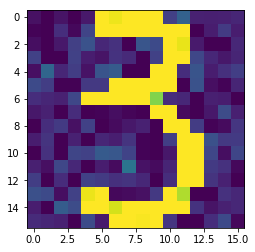

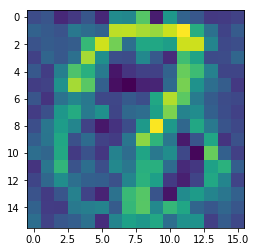

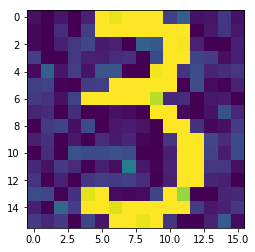

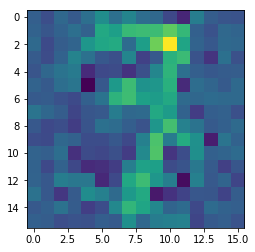

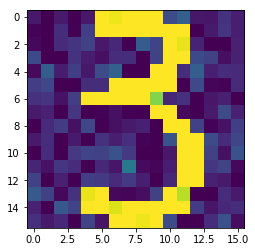

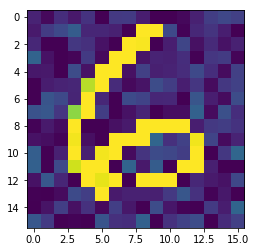

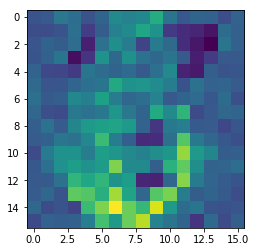

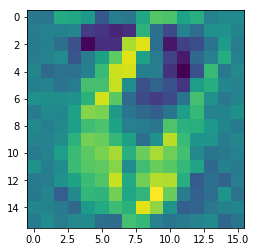

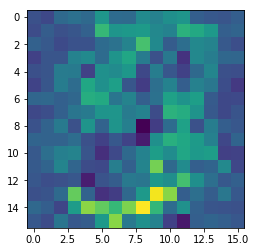

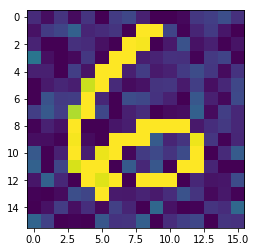

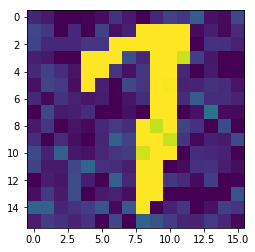

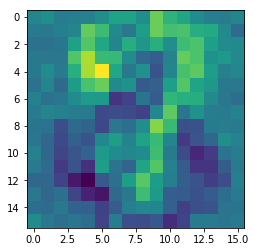

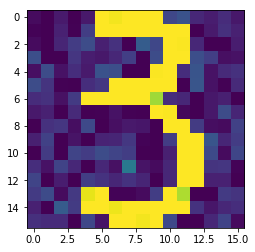

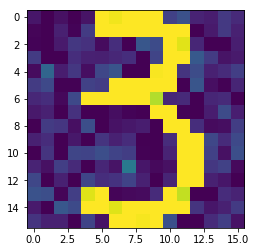

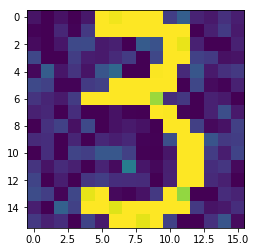

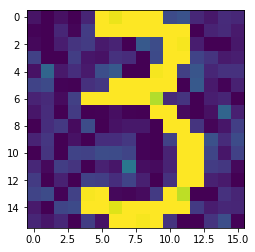

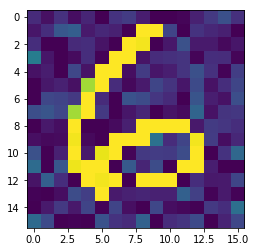

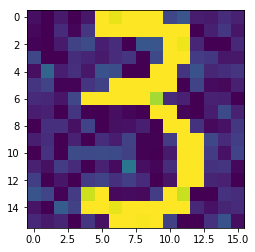

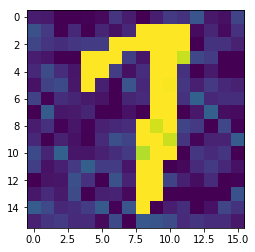

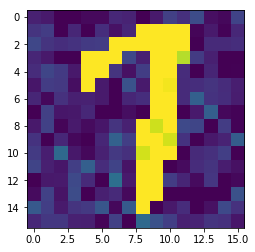

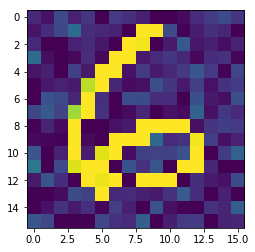

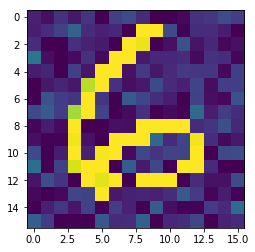

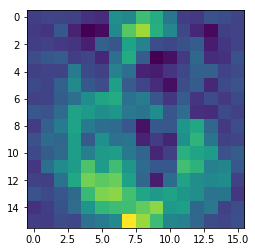

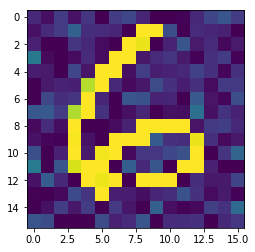

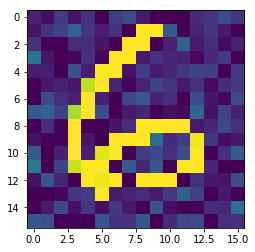

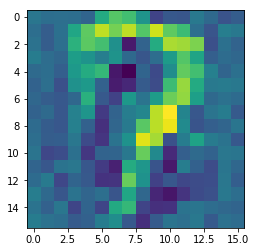

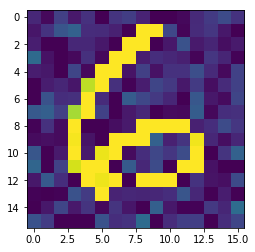

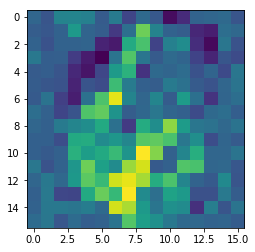

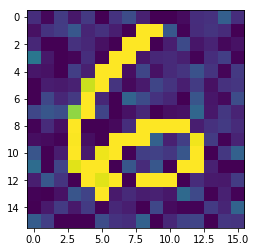

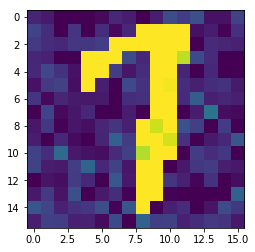

In [85]:
Noisy_Mixture = NoisyMixtureModel()
Likelihoods_N = Noisy_Mixture.fit(x)
samples = Noisy_Mixture.sample(30)
for i in range(0,30):
    Sample = samples[i].T
    plt.imshow(Sample.reshape(16,16))
    plt.show()